# Integer Quadratic Programming

Primal problem:
* `minimize` $\sum_{t=1}^{m}\left(k_t-x_t\right)^2 + \rho\sum_{i=1}^{n}\sum_{j=1}^{q}\chi_{(i, j)}$

subject to constraints:
1. $\frac{\alpha_t}{n} \le x_t \le \alpha_t,$ $\forall t=1,2, \dots, m$
2. $x_t \in \left[0, k_t\right],$ $\forall t = 1, 2, \dots, m$
3. $\sum_{j=1}^{q}\chi_{(i, j)} \le 1,$ $\forall i = 1, 2, \dots, n$
4. $\chi_{(i, j)} \in \{0, 1\},$ $\forall i=1, 2, \dots, n,$ $\forall j=1,2, \dots, q$

We have $m+nq$ variables and $2m+n+nq$ constraints

**IQP**

\begin{split}\begin{array}{ll}
\mbox{minimize}   & x^T Q x + q^T x + r \\
\mbox{subject to} & \mathbf{x} \in \mathcal{C}\\
& \mathbf{x} \in \mathbf{Z}^n,
\end{array}\end{split}

$\mathcal{C}$ is convex set


$\DeclareMathOperator{\diag}{diag}$
Denote:
* $\mathbf{k} = \left(k_1, k_2, \dots,k_m, 0, \dots, 0\right)$
* $\mathbf{d} = \left(0, \dots, 0, \rho, \dots, \rho\right)$
* $\mathbf{x} = \left(x_1, x_2, \dots, x_l\right)$
* $\mathbf{A} = \mathbf{I}_l^{(m)}$

With $l=$ len_var
The first term in primal problem $\Leftrightarrow$

`minimize` $||\mathbf{A}\mathbf{x} - \mathbf{k}||_2^2 + \mathbf{d}^T\mathbf{x}$

$||\mathbf{A}\mathbf{x} - \mathbf{k}||_2^2 + \mathbf{d}^T\mathbf{x} = \left(\mathbf{A}\mathbf{x} - \mathbf{k}\right)^T\left(\mathbf{A}\mathbf{x} - \mathbf{k}\right) + \mathbf{d}^T\mathbf{x}
=\mathbf{x}^T\mathbf{A}^T\mathbf{A}\mathbf{x} + \left(\mathbf{d}-2\mathbf{A}^T\mathbf{k}\right)^T\mathbf{x}+\mathbf{k}^T\mathbf{k}$

Identity:
* $\mathbf{Q} = \mathbf{A}^T\mathbf{A} = \mathbf{I}_l^{(m)}$
* $\mathbf{p} = \mathbf{d} - 2\mathbf{A}^T\mathbf{k}$
* $r = \mathbf{k}^T\mathbf{k}$

# Implementation

In [1]:
!pip install xpress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 MB 4.0 MB/s eta 0:00:00


In [ ]:
# !pip install cplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install Mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 83.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import cvxpy as cp
import xpress
from matplotlib import pyplot as plt
from matplotlib import patches as ptc
import tqdm
import json
import pickle
import pandas as pd

## Prepare data

In [3]:
!gdown 1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
!gdown 1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE

Downloading...
From: https://drive.google.com/uc?id=1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
To: /content/fix_targets.pkl
100% 4.21M/4.21M [00:00<00:00, 23.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE
To: /content/fix_sensors.pkl
100% 4.45M/4.45M [00:00<00:00, 24.1MB/s]


In [4]:
with open("/content/fix_sensors.pkl", 'rb') as f:
  fs_data = pickle.load(f)

with open("/content/fix_targets.pkl", 'rb') as f:
  ft_data = pickle.load(f)


## Utils

In [ ]:
def make_pan_boundaries(centroid, q, radius):
    # first line always lies on x_axis
    ans = []
    theta = 2*np.pi/q
    for i in range(q):
        x = radius*np.cos(theta*i)
        y = radius*np.sin(theta*i)
        ans.append((centroid[0] + x, centroid[1] + y))

    return ans

In [ ]:
def show_network(network, sensors_mask=None, figsize=None):
    if figsize is not None:
      plt.figure(figsize=(figsize, figsize))

    x_lim = network['margin'][0]
    y_lim = network['margin'][1]

    targets = network['targets']
    sensors = network['sensors']
    radius = network['radius']
    q = network['q']
    tar_x = [i[0] for i in targets]
    tar_y = [i[1] for i in targets]
    plt.plot(tar_x, tar_y, 'r^', label='targets')
    sen_x = [i[0] for i in sensors]
    sen_y = [i[1] for i in sensors]
    plt.plot(sen_x, sen_y, 'go', label='sensors')
    ax = plt.gca()

    for i in range(len(sensors)):
        sensor = sensors[i]
        active = True

        if sensors_mask is not None:
            active = False
            theta = 360.0/q
            for j in range(q):
                if sensors_mask[q*i+j] == 1:
                    active = True
                    theta1, theta2 = theta*j, theta*(j+1)
                    wedge = ptc.Wedge(sensors[i], radius, theta1, theta2, color='#34e1eb', alpha=0.45)
                    ax.add_artist(wedge)
        if active:
          # if sensors_mask is not None:
          #   plt.annotate(f's{i}', sensors[i], textcoords='offset points', xytext=(0, 5), ha='center')
          circle = plt.Circle(sensor, radius, color='m', fill=False, linewidth=1)
          ax.add_artist(circle)
          pan_boundaries = make_pan_boundaries(sensor, q, radius)
          for point in pan_boundaries:
              plt.plot([sensor[0], point[0]], [sensor[1], point[1]], 'b--', alpha=0.2)

    plt.xlim([x_lim[0], x_lim[1]])
    plt.ylim([y_lim[0], y_lim[1]])
    ax.set_aspect(1.0)  # make aspect ratio square

    plt.legend()

    plt.show()

In [5]:
def is_within_FoV(bisector, target, sensor, radius):
    target = np.asarray(target)
    sensor = np.asarray(sensor)
    bisector = np.asarray(bisector)
    v = target - sensor
    dist = np.linalg.norm(v)
    scalar = bisector.dot(v)
    return scalar + 1e-7 >= radius*dist*np.cos(np.pi/8) and dist - 1e-7 <= radius

def init_Gt(m, n, q, radius, targets, sensors):
    Gt = np.zeros((m, n*q))
    bisectors = []
    for i in range(8):
        bisectors.append((radius*np.cos(np.pi/8+i*np.pi/4), radius*np.sin(np.pi/8+i*np.pi/4)))

    for i in range(m):
        for j in range(n):
            for k in range(q):
                Gt[i, q*j+k] = is_within_FoV(bisectors[k], targets[i], sensors[j], radius)
    return Gt


## Represent input

In [ ]:
# initialize m, n, q
network = data['fixed-target']['small'][102]
m = network['m']    # number of targets
n = network['n']    # number of sensors
q = network['q']    # number of pans
targets = network['targets']
sensors = network['sensors']
radius = network['radius']
K = np.asarray(network['K'])
len_var = m + n*q
rho = 0.0001
print(f'{len_var} variables')

870 variables


In [ ]:
# initialize constants
Gt = init_Gt(m,n, q, radius, targets, sensors)

In [ ]:
# check Gt
for i in range(m):
    print(f'Target {i} with pos {targets[i]} tracked by:')

    for j in range(n):
            for k in range(q):
                if Gt[i, q*j+k] == 1:
                    print(f'\tSensor {j} with pos {sensors[j]} at pan {k}')


Target 0 with pos [ 43.22334752 152.96992276] tracked by:
	Sensor 12 with pos [ 47.09020376 134.42934815] at pan 2
	Sensor 34 with pos [ 28.53576027 150.15536637] at pan 0
	Sensor 48 with pos [ 54.68777761 145.11543907] at pan 3
	Sensor 99 with pos [ 50.48924723 169.6991394 ] at pan 5
Target 1 with pos [175.27001249 177.81109531] tracked by:
Target 2 with pos [ 46.25941763 166.34406098] tracked by:
	Sensor 45 with pos [ 56.26106041 181.80141944] at pan 5
	Sensor 57 with pos [ 38.76117183 180.95600469] at pan 6
	Sensor 99 with pos [ 50.48924723 169.6991394 ] at pan 4
Target 3 with pos [191.70903551 186.58681296] tracked by:
	Sensor 40 with pos [182.08647907 198.51246043] at pan 6
Target 4 with pos [166.49086512 100.69170847] tracked by:
Target 5 with pos [49.15838085 75.40813837] tracked by:
	Sensor 23 with pos [64.33552504 84.80976169] at pan 4
	Sensor 29 with pos [58.82714606 86.55416666] at pan 5
	Sensor 71 with pos [45.89391465 79.69292294] at pan 6
Target 6 with pos [62.39223256 84

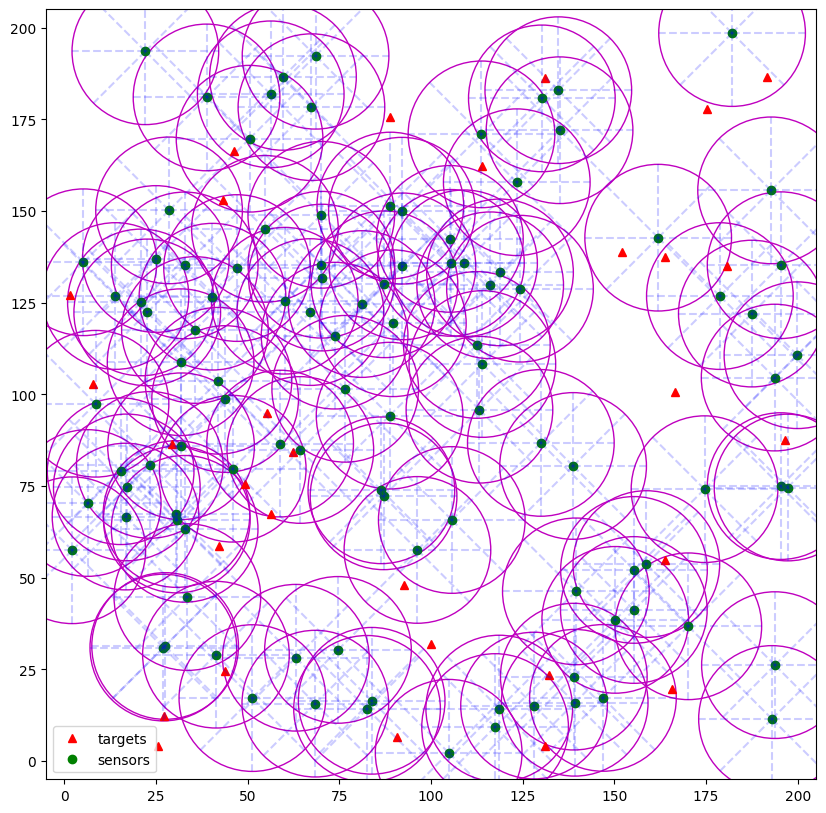

In [ ]:
show_network(network, figsize=10)

## Make function for solving IQP

In [6]:
def solve_IQP(network):
  m = network['m']    # number of targets
  n = network['n']    # number of sensors
  q = network['q']    # number of pans
  targets = network['targets']
  sensors = network['sensors']
  radius = network['radius']
  K = np.asarray(network['K'])
  len_var = m + n*q
  rho = 0.0001
  Gt = init_Gt(m, n, q, radius, targets, sensors)

  Q = np.zeros((len_var, len_var))
  for i in range(m):
      Q[i, i] = 1

  p = np.zeros((len_var,))
  p[0:m] = -2*K
  p[m:] = rho*np.ones((n*q,))

  r = K.dot(K)

  # constraint 1
  A1 = np.zeros((m, len_var))
  for i in range(m):
      A1[i, i] = 1
      A1[i, m:] = -Gt[i]
  lower_bound_1 = np.full((m,), -np.inf)
  upper_bound_1 = np.zeros((m,))

  # constraint 2
  A2 = np.zeros((m, len_var))
  for i in range(m):
      A2[i, i] = 1
      A2[i, m:] = -Gt[i]/m
  lower_bound_2 = np.zeros((m,))
  upper_bound_2 = np.full((m,), np.inf)

  # constraint 3
  A3 = np.zeros((n, len_var))
  for i in range(n):
      A3[i, m+q*i: m+q*i+q] = np.ones((q,))
  lower_bound_3 = np.zeros((n,))
  upper_bound_3 = np.ones((n,))

  # bound
  lower_bound_4 = np.zeros((len_var,))
  upper_bound_4 = np.concatenate((K, np.ones((n*q,))))

  # Construct a Integer Quadratic Programming
  x = cp.Variable(len_var, integer=True)

  objective_func = x.T @ Q @ x + p.T @ x + r
  objective = cp.Minimize(objective_func)

  constraints = [
                A2@x >= lower_bound_2,
                A3@x >= lower_bound_3,
                A3@x <= upper_bound_3,
      A1@x <= upper_bound_1,

                x >= lower_bound_4,
                x <= upper_bound_4]

  prob = cp.Problem(objective, constraints)

  min_value = prob.solve(solver=cp.XPRESS)
  achieved_coverage = x.value[:m]
  sensors_mask = x.value[m:]

  return min_value, achieved_coverage, sensors_mask


## Solve IQP

In [ ]:
min_value, achieved_coverage, sensors_mask = solve_IQP(network)
min_value

28.004099999999994

## Result

In [ ]:
achieved_coverage

array([ 1.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  2.,  2.,  3.,  2.,  1.,
        3.,  1.,  1.,  2.,  3.,  1.,  1.,  1., -0.,  2.,  1.,  1.,  2.,
        1.,  2.,  2.,  1.])

In [ ]:
sensors_mask

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  1.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0.,  1., -0., -0.,  0.,
       -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  1., -0., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0

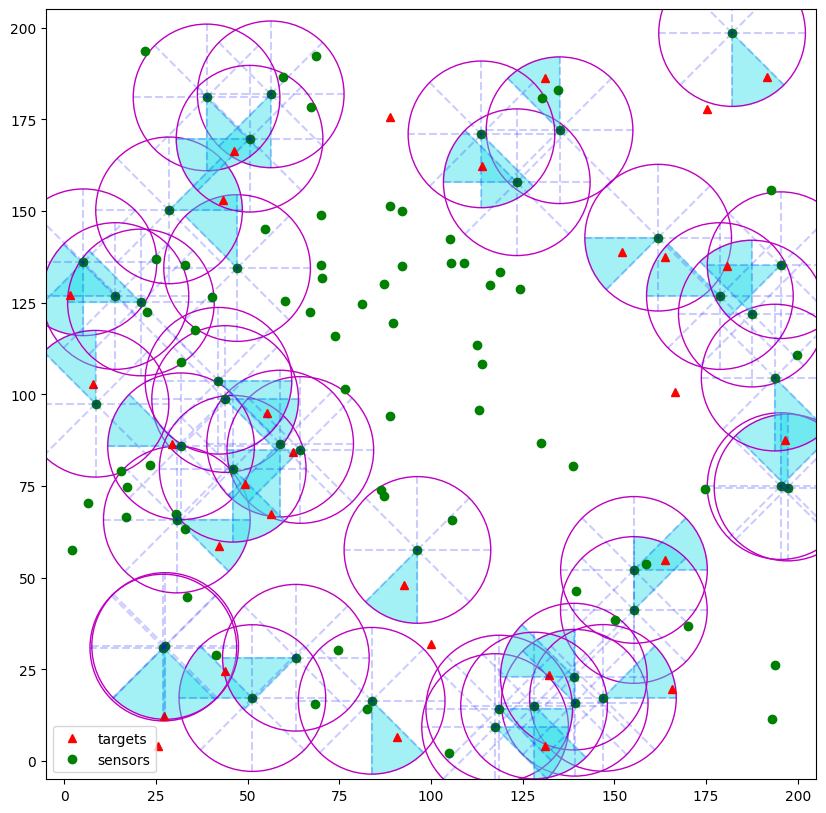

In [ ]:
show_network(network, sensors_mask, figsize=10)

# Performane metrics

## Distance index

In [ ]:
def distance_index(k, x):
  a = np.sum(k*k)
  b = k - x
  b = np.sum(b*b)
  return (a-b)/a

## Variance

In [ ]:
def variance(k, x):
  m = len(x)
  mk = np.zeros_like(x)
  for t in range(m):
    mk[t] = np.sum(k == k[t])
  mu_k = np.zeros_like(x)
  for t in range(m):
    ans = 0
    for i in range(m):
      ans += x[i]*(k[i] == k[t])
    mu_k[t] = ans/mk[t]

  a = (x - mu_k)

  return np.sum(a*a/mk)

## Activated sensors

In [8]:
def activated_sensors(n_sensors, q, mask):
  cnt = 0
  for i in range(n_sensors):
    for j in range(q):
      if mask[q*i+j] == 1:
        cnt += 1

  return cnt

## Coverage quality

In [ ]:
def coverage_quality(mask, network):
  sensors = network['sensors']
  targets = network['targets']
  radius = network['radius']
  n = network['n']
  m = network['m']
  q = network['q']
  T = np.zeros((n, q, m), dtype=bool)

  bisectors = []
  for i in range(q):
      bisectors.append((radius*np.cos(np.pi*(1 + i*2)/q), radius*np.sin(np.pi*(1 + i*2)/q)))

  for i in range(n):
      for j in range(m):
          for p in range(q):
              T[i, p, j] = is_within_FoV(bisectors[p], targets[j], sensors[i], radius)

  U = np.zeros((n, q, m), dtype=float)
  for i in range(n):
    for j in range(m):
        for p in range(q):
          if T[i, p, j]:
            target = np.asarray(targets[j])
            sensor = np.asarray(sensors[i])
            v = target - sensor
            U[i, p, j] = 1 - np.square(np.linalg.norm(v)/radius)

  S = np.zeros((n, q), dtype=bool)
  for i in range(n):
    for j in range(q):
      if mask[i*q+j] == 1:
        S[i, j] = True

  return np.sum(np.sum(U, axis=2)*S)

# Evaluate

## Fixed sensor

In [ ]:
DI_fs_small = []
VAR_fs_small = []
CQ_fs_small = []
for i in range(10):
  di = []
  var = []
  cq = []
  for dt in tqdm.tqdm(fs_data[i]['small']):
    _, achieved_coverage, mask = solve_IQP(dt)
    DI_score = distance_index(np.asarray(dt['K']), achieved_coverage)
    var_score = variance(np.asarray(dt['K']), achieved_coverage)
    cq_score = coverage_quality(mask, dt)
    di.append(DI_score)
    var.append(var_score)
    cq.append(cq_score)
  DI_fs_small.append(di)
  VAR_fs_small.append(var)
  CQ_fs_small.append(cq)


  0%|          | 0/118 [00:00<?, ?it/s]

Using the Community license in this session. If you have a full Xpress license, pass the full path to your license file to xpress.init(). If you want to use the FICO Community license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/usr/local/lib/python3.10/dist-packages/xpress/license/community-xpauth.xpr')


100%|██████████| 118/118 [01:00<00:00,  1.95it/s]


In [ ]:
DI_fs_avg = np.mean(DI_fs_small, axis=0)
VAR_fs_avg = np.mean(VAR_fs_small, axis=0)
CQ_fs_avg = np.mean(CQ_fs_small, axis=0)

In [ ]:
# di_fs
!gdown 1P23JyCqFMy7ddK6_Jacj1xxYMfB2RfF9
# var_fs
!gdown 1KjRyOXaq6u00A70jOs6vRltAR9R8ys1T
# cq_fs
!gdown 1iVULuTB-76Yf8g9ZN3N241MGjUwX_FwX

Downloading...
From: https://drive.google.com/uc?id=1P23JyCqFMy7ddK6_Jacj1xxYMfB2RfF9
To: /content/Distance_Index_fs.csv
100% 4.90k/4.90k [00:00<00:00, 7.18MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KjRyOXaq6u00A70jOs6vRltAR9R8ys1T
To: /content/Variance_fs.csv
100% 4.70k/4.70k [00:00<00:00, 15.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iVULuTB-76Yf8g9ZN3N241MGjUwX_FwX
To: /content/CQ_fs.csv
100% 4.74k/4.74k [00:00<00:00, 16.5MB/s]


In [ ]:
di_fs = pd.read_csv('/content/Distance_Index_fs.csv')
var_fs = pd.read_csv('/content/Variance_fs.csv')
cq_fs = pd.read_csv('/content/CQ_fs.csv')

In [ ]:
df = pd.DataFrame({'ILP': di_fs['ILP'],
                   'IQP': DI_fs_avg,
                   'PIQP': di_fs['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/Distance_Index_fs.csv')


df = pd.DataFrame({'ILP': var_fs['ILP'],
                   'IQP': VAR_fs_avg,
                   'PIQP': var_fs['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/Variance_fs.csv')


df = pd.DataFrame({'ILP': cq_fs['ILP'],
                   'IQP': CQ_fs_avg,
                   'PIQP': cq_fs['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/CQ_fs.csv')

### Distance index

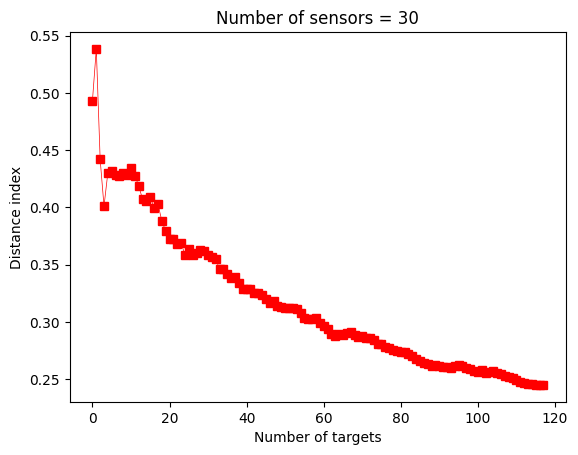

In [ ]:
x_axis = np.arange(len(DI_fs_avg))
plt.plot(x_axis, DI_fs_avg, 'r-', linewidth=0.5)
plt.plot(x_axis, DI_fs_avg, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Distance index")
plt.title(f'Number of sensors = {30}')
plt.show()

### Variance

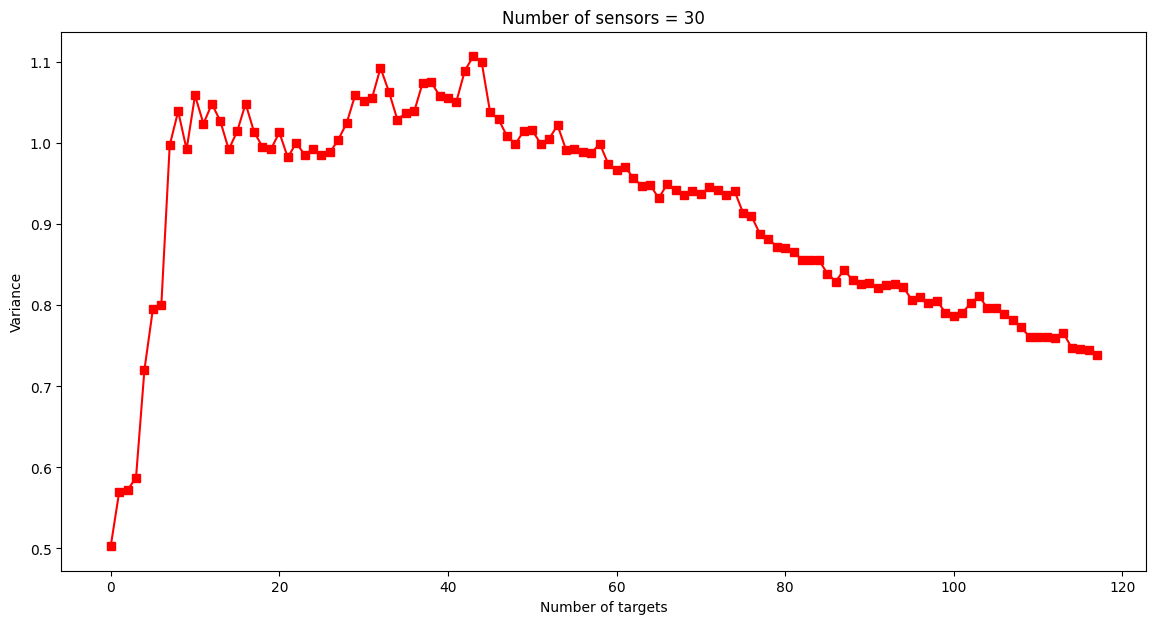

In [ ]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(VAR_fs_avg))
plt.plot(x_axis, VAR_fs_avg, 'r-')
plt.plot(x_axis, VAR_fs_avg, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Variance")
plt.title(f'Number of sensors = {30}')
plt.show()

### Coverage Quality

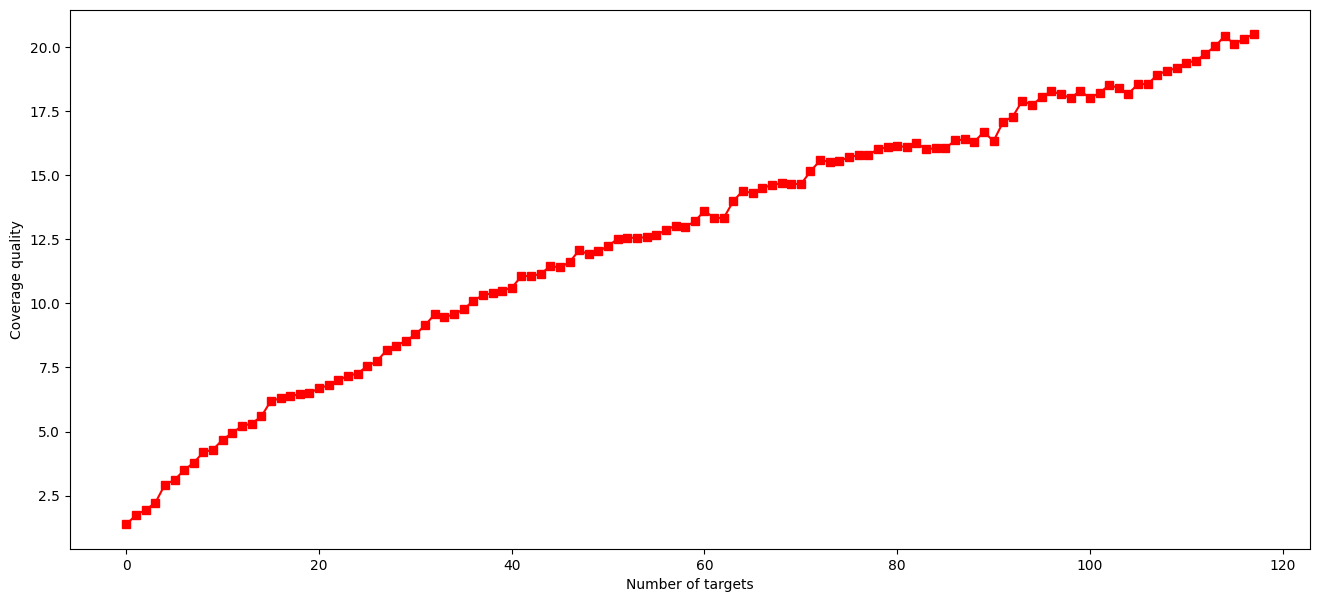

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(CQ_fs_avg))
plt.plot(x_axis, CQ_fs_avg, 'r-')
plt.plot(x_axis, CQ_fs_avg, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Coverage quality")
plt.show()

In [7]:
index = range(0, 118, 3)

In [9]:
ACT_fs_iqp = []
for i in range(10):
  act = []
  for id in tqdm.tqdm(index):
    dt = fs_data[i]['small'][id]
    _, achieved_coverage, mask = solve_IQP(dt)
    act_score = activated_sensors(dt['n'], dt['q'], mask)
    act.append(act_score)
  ACT_fs_iqp.append(act)

  0%|          | 0/40 [00:00<?, ?it/s]

Using the Community license in this session. If you have a full Xpress license, pass the full path to your license file to xpress.init(). If you want to use the FICO Community license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/usr/local/lib/python3.10/dist-packages/xpress/license/community-xpauth.xpr')


100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


In [10]:
ACT_fs_avg_iqp = np.mean(ACT_fs_iqp, axis=0)

In [11]:
with open("/content/act_fs_iqp.npy", "wb") as f:
  np.save(f, ACT_fs_avg_iqp)

In [12]:
ACT_fs_avg_iqp

array([ 2.6,  4.1,  6.4,  8.3, 10.1, 11.5, 12.4, 13.3, 14.1, 15.5, 17.1,
       18.4, 18.9, 19.7, 20.5, 21. , 21.6, 22.3, 22.8, 23.3, 23.8, 24.1,
       24.8, 25.1, 25.7, 25.8, 25.7, 25.9, 26.2, 26.6, 26.7, 27.4, 27.6,
       27.6, 27.8, 28. , 28.3, 28.1, 28.3, 28.3])

## Fixed target

In [ ]:
DI_ft_small = []
VAR_ft_small = []
CQ_ft_small = []
for i in range(10):
  di = []
  var = []
  cq = []
  for dt in tqdm.tqdm(ft_data[i]['small']):
    _, achieved_coverage, mask = solve_IQP(dt)
    DI_score = distance_index(np.asarray(dt['K']), achieved_coverage)
    var_score = variance(np.asarray(dt['K']), achieved_coverage)
    cq_score = coverage_quality(mask, dt)
    di.append(DI_score)
    var.append(var_score)
    cq.append(cq_score)
  DI_ft_small.append(di)
  VAR_ft_small.append(var)
  CQ_ft_small.append(cq)


100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


In [ ]:
DI_ft_avg = np.mean(DI_ft_small, axis=0)
VAR_ft_avg = np.mean(VAR_ft_small, axis=0)
CQ_ft_avg = np.mean(CQ_ft_small, axis=0)

### Distance index

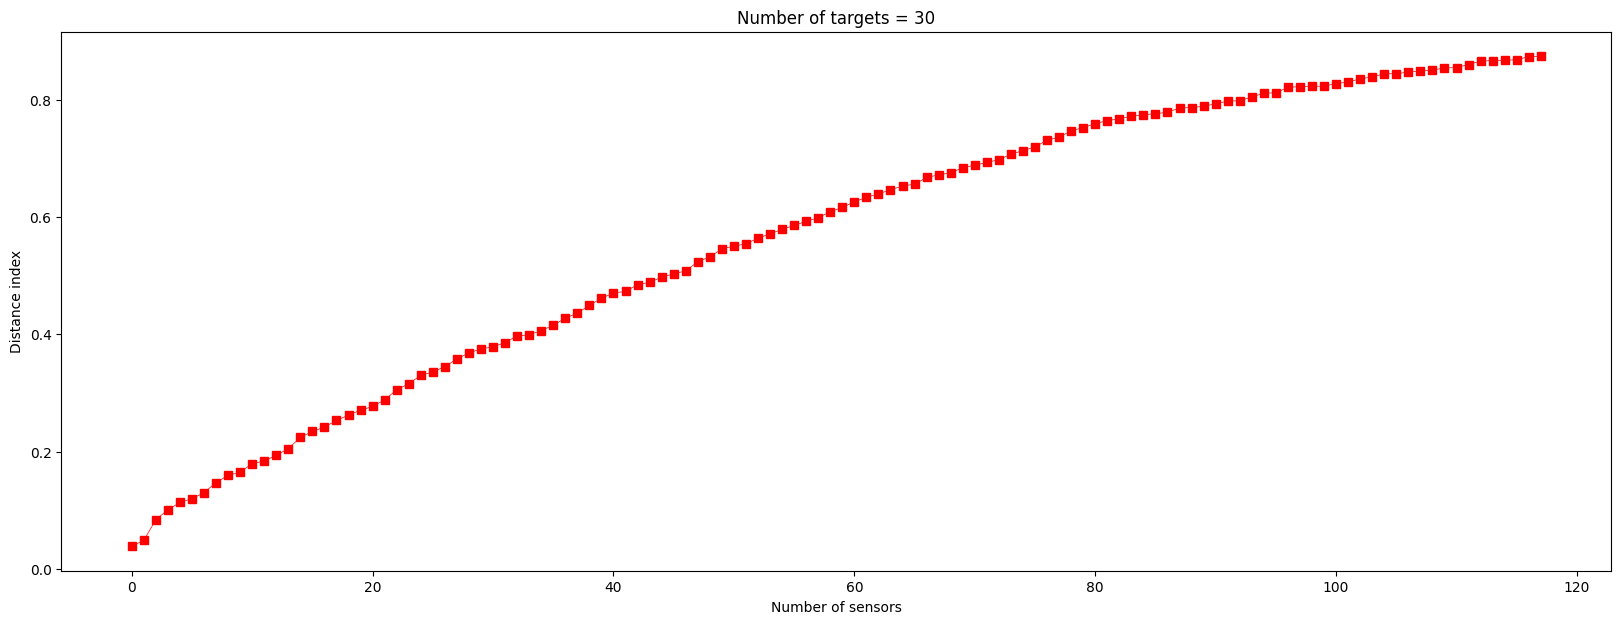

In [ ]:
plt.figure(figsize=(20, 7))
x_axis = np.arange(len(DI_ft_avg))
plt.plot(x_axis, DI_ft_avg, 'r-', linewidth=0.5)
plt.plot(x_axis, DI_ft_avg, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Distance index")
plt.title(f'Number of targets = {30}')
plt.show()

### Variance

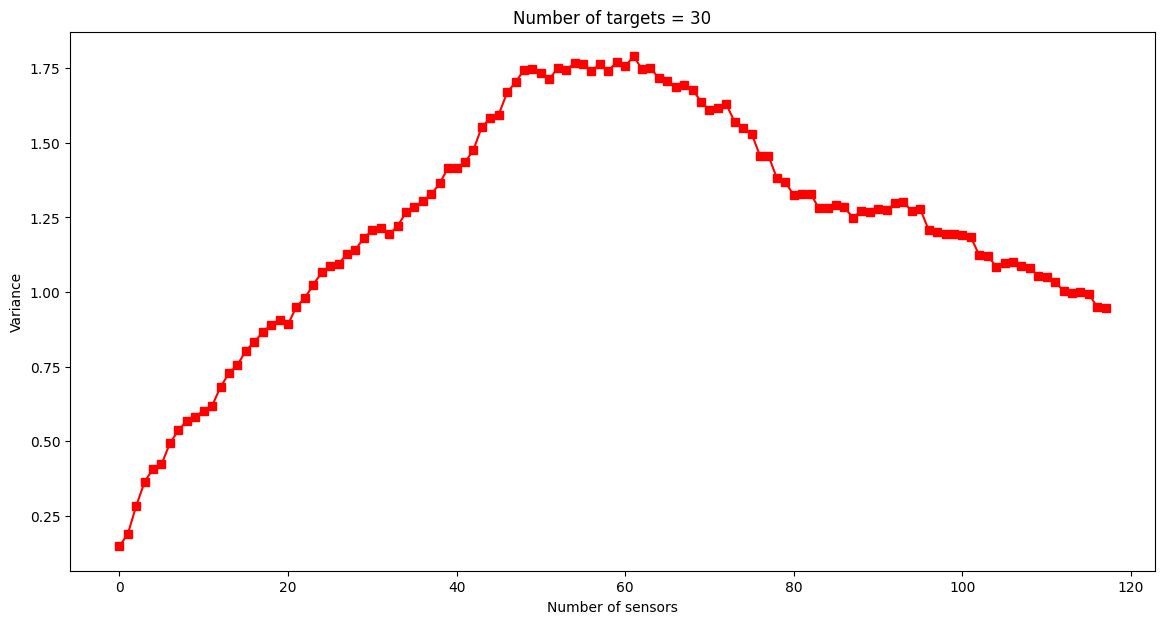

In [ ]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(VAR_ft_avg))
plt.plot(x_axis, VAR_ft_avg, 'r-')
plt.plot(x_axis, VAR_ft_avg, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Variance")
plt.title(f'Number of targets = {30}')
plt.show()

### Coverage Quality

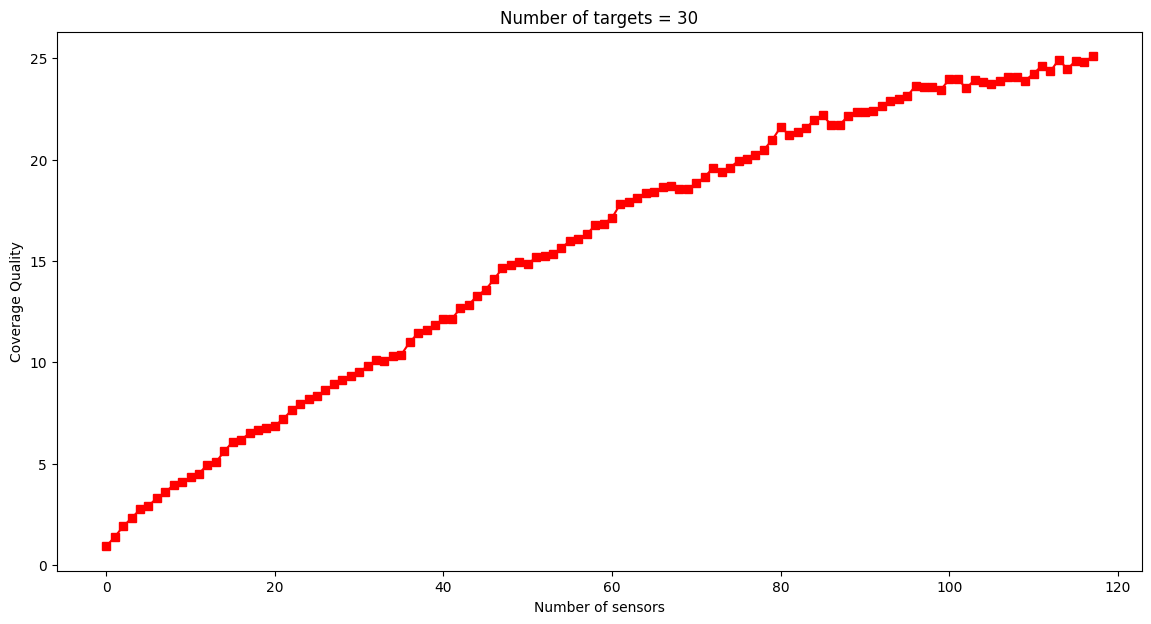

In [ ]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(CQ_ft_avg))
plt.plot(x_axis, CQ_ft_avg, 'r-')
plt.plot(x_axis, CQ_ft_avg, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Coverage Quality")
plt.title(f'Number of targets = {30}')
plt.show()

### Activated sensors

In [ ]:
ACT_ft_small = []
for i in range(10):
  act = []
  for dt in tqdm.tqdm(ft_data[i]['small']):
    _, achieved_coverage, mask = solve_IQP(dt)
    act_score = activated_sensors(dt['n'], dt['q'], mask)
    act.append(act_score)
  ACT_ft_small.append(act)


100%|██████████| 118/118 [00:42<00:00,  2.76it/s]


In [ ]:
ACT_ft_avg = np.mean(ACT_ft_small, axis=0)

In [ ]:
# di_ft
!gdown 1sjw9d-zu6rJZciXBBr02YKdAR4Us_puN
# var_ft
!gdown 19rYNLsbrG-Mn_JpFxgh6Ni-NqQ3yhIru
# cq_ft
!gdown 1iT5_kJtJW-k0qZ_R8efLH0WwydtEwwJk
# act
!gdown 1be7pDTxEIFiPBK-_hQ88GOJo42UgPhQ5

Downloading...
From: https://drive.google.com/uc?id=1sjw9d-zu6rJZciXBBr02YKdAR4Us_puN
To: /content/Distance_Index_ft.csv
100% 4.86k/4.86k [00:00<00:00, 19.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=19rYNLsbrG-Mn_JpFxgh6Ni-NqQ3yhIru
To: /content/Variance_ft.csv
100% 4.78k/4.78k [00:00<00:00, 18.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iT5_kJtJW-k0qZ_R8efLH0WwydtEwwJk
To: /content/CQ_ft.csv
100% 4.72k/4.72k [00:00<00:00, 18.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1be7pDTxEIFiPBK-_hQ88GOJo42UgPhQ5
To: /content/Active_sensors.csv
100% 2.91k/2.91k [00:00<00:00, 12.3MB/s]


In [ ]:
di_ft = pd.read_csv('/content/Distance_Index_ft.csv')
var_ft = pd.read_csv('/content/Variance_ft.csv')
cq_ft = pd.read_csv('/content/CQ_ft.csv')
act = pd.read_csv('/content/Active_sensors.csv')

In [ ]:
df = pd.DataFrame({'ILP': di_ft['ILP'],
                   'IQP': DI_ft_avg,
                   'PIQP': di_ft['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/Distance_Index_ft.csv')


df = pd.DataFrame({'ILP': var_ft['ILP'],
                   'IQP': VAR_ft_avg,
                   'PIQP': var_ft['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/Variance_ft.csv')


df = pd.DataFrame({'ILP': cq_ft['ILP'],
                   'IQP': CQ_ft_avg,
                   'PIQP': cq_ft['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/CQ_ft.csv')


df = pd.DataFrame({'ILP': act['ILP'],
                   'IQP': ACT_ft_avg,
                   'PIQP': act['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/Activated_sensors.csv')